* On importe les modules  :

In [2]:
import numpy as np
import pandas as pd #manipulation des données, calculs.
import pandas_datareader.data as web #téléchargement de données financières via API.
import matplotlib.pyplot as plt
from matplotlib import style 
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime as dt

* On met en place notre DataFrame correctement

C:\Users\alexa\AppData\Local\Temp\ipykernel_18520\771382096.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start, end)
[*********************100%***********************]  1 of 1 completed


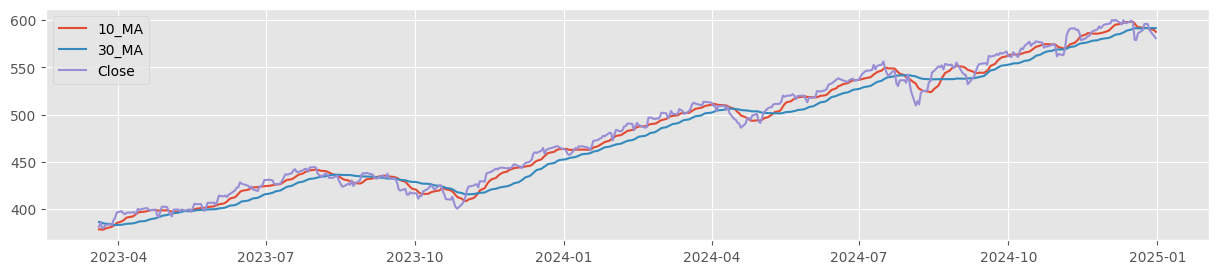

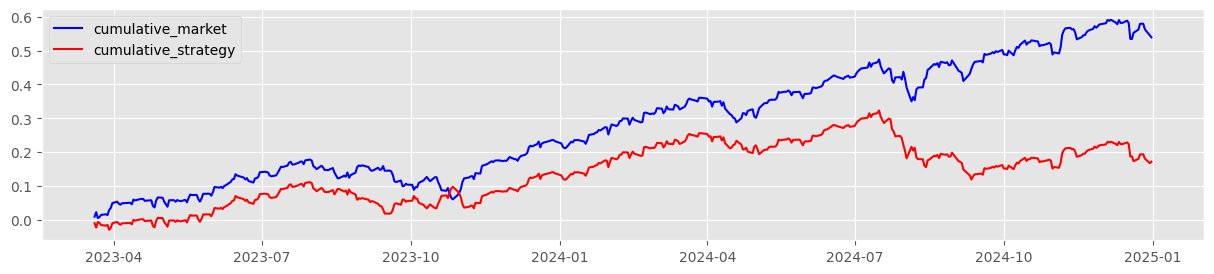

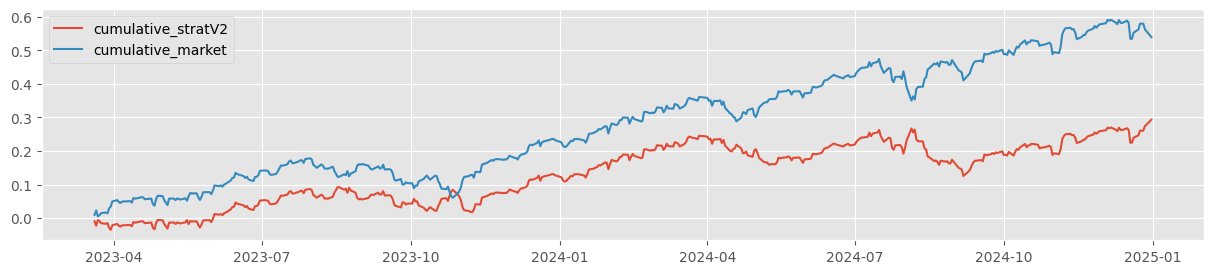

In [4]:
TICKER = 'SPY' 
FAST = 10
SLOW = 30
LOOKBACK = 500

def get_data():
    start = dt.datetime(1980,1,1)
    end = dt.datetime(2025,1,1)
    df = yf.download(TICKER, start, end)
    df.columns = df.columns.get_level_values(0) # eviter les problèmes d'indexage (enlevela ligne TICKER)
    
    # on ne que prendre le troncon qui nous interesse
    return df.iloc[-LOOKBACK:, :]

def add_ma(df, fast, slow, window):
    df['MA'] = df['Close'].rolling(window).mean()
    df[f'{FAST}_MA'] = df['Close'].rolling(fast).mean()
    df[f'{SLOW}_MA'] = df['Close'].rolling(slow).mean()
    return df.dropna()

def add_strat(df, fast, slow):
    df['strategy_signal'] = np.where(df['Close'] > df['MA'], 1, -1 )
    df['signal_stratV2'] = np.where(df[f'{fast}_MA'] > df[f'{slow}_MA'], 1, -1 )
    return df

def test_strat(df):

    # rendements (journaliers) :
    df['market_returns'] = df['Close'].pct_change().fillna(0)
    df['strategy_returns'] = df['Close'].pct_change() * df['strategy_signal'].shift(1) # decallage de 1 jour car on ne veut pas tricher
    df['return_stratV2'] = df['Close'].pct_change() * df['signal_stratV2'].shift(1)

    #cumulative : lequel est le mieux ?
    df['cumulative_market'] = (1 + df['market_returns']).cumprod() - 1
    df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod() - 1
    df['cumulative_stratV2'] = (1 + df['return_stratV2']).cumprod() - 1
    return df.dropna()

df = get_data()
df = add_ma(df, FAST, SLOW, 50)
df = add_strat(df, FAST, SLOW)
df = test_strat(df)
 

# Visualizer les diff MA
plt.figure(figsize=(15, 3))
plt.plot(df[f'{FAST}_MA'])
plt.plot(df[f'{SLOW}_MA'])
plt.plot(df['Close'])
plt.legend([f'{FAST}_MA', f'{SLOW}_MA', 'Close'])
plt.show()

# Ploting the difference
plt.style.use("ggplot")
plt.figure(figsize=(15, 3))
plt.plot(df['cumulative_market'], color="blue")
plt.plot(df['cumulative_strategy'], color = 'red')
plt.legend(['cumulative_market','cumulative_strategy'])
plt.show()


# est-ce que on va battre le S&P500 ?
plt.figure(figsize=(15, 3))
plt.plot(df['cumulative_stratV2'])
plt.plot(df['cumulative_market'])
plt.legend(['cumulative_stratV2', 'cumulative_market'])
plt.show()




